# Analísis Exploratorio de los Datos

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('default')
sns.set_palette('husl')


In [2]:
dataset = pd.read_csv('../data/data_transactions.csv')

In [3]:
dataset.head()

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
0,user_51,recarga,19821.54,474314.99,494136.53,2023-01-01 00:00:00,0
1,user_92,recarga,5743.16,217815.04,223558.20,2023-01-01 00:01:00,0
2,user_14,retiro,17011.92,11710.15,-5301.77,2023-01-01 00:02:00,0
3,user_71,recarga,26655.67,469606.25,496261.92,2023-01-01 00:03:00,0
4,user_60,recarga,33147.40,16918.13,50065.53,2023-01-01 00:04:00,0


In [4]:
dataset.tail()

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
9995,user_15,recarga,38723.21,400275.82,438999.03,2023-01-07 22:35:00,0
9996,user_16,recarga,13939.31,308558.02,322497.33,2023-01-07 22:36:00,0
9997,user_79,retiro,19073.72,440061.75,420988.03,2023-01-07 22:37:00,0
9998,user_18,retiro,8625.07,359459.44,350834.37,2023-01-07 22:38:00,0
9999,user_7,recarga,6982.52,387260.83,394243.35,2023-01-07 22:39:00,0


In [5]:
dataset.describe()

,amount,balance_before,balance_after,is_anomaly
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000
mean,4.845413e+04,254697.230031,2.672200e+05,0.010400
std,3.154764e+05,141770.476819,3.483824e+05,0.101454
min,1.000000e+03,10008.200000,-4.621451e+06,0.000000
25%,1.168429e+04,130533.632500,1.365646e+05,0.000000
50%,1.818234e+04,254952.050000,2.628995e+05,0.000000
75%,2.474222e+04,377613.022500,3.852559e+05,0.000000
max,4.995116e+06,499986.350000,5.417279e+06,1.000000


Aquí se debe tener en cuenta que solo un 1% de los datos son anomalías, por lo tanto se debe tener cuidado a la hora de splitear los datos para hacer random forest u otros de forma aleatoria, ya que puede que varios árboles no tengan ningún ejemplo de anomalía o estén heavily biased por unos pocos datapoints en el dataset. 

In [6]:
dataset.describe(include="object")

,user_id,transaction_type,timestamp
count,10000,10000,10000
unique,100,2,10000
top,user_16,recarga,2023-01-01 00:00:00
freq,126,6105,1


Solo hay dos tipos de transacciones. Recargas y retiros. Hay un total de 100 usuarios, de los cuales el usuario 16 tiene la mayor cantidad de transacciones realizadas.

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  object 
 1   transaction_type  10000 non-null  object 
 2   amount            10000 non-null  float64
 3   balance_before    10000 non-null  float64
 4   balance_after     10000 non-null  float64
 5   timestamp         10000 non-null  object 
 6   is_anomaly        10000 non-null  int64  
dtypes: float64(3), int64(1), object(3)
memory usage: 547.0+ KB


In [8]:
# Double check de que no existan valores vacíos.
# Efectivamente es un dataset ideal
missing_data = dataset.isnull().sum()
missing_percentage = (missing_data / len(dataset)) * 100

missing_percentage

user_id             0.0
transaction_type    0.0
amount              0.0
balance_before      0.0
balance_after       0.0
timestamp           0.0
is_anomaly          0.0
dtype: float64

No hay datos vacíos en el dataset. Por lo que no debemos aplicar ninguna técnica para llenarlos.

## Feature Engineering

Dado que no hay ningún dato vacío, y no hay un indicador claro de que variables pueden ser features fuertes para un modelo predictivo, vamos a aislar las anomalías para ver si tienen una diferencia significativa con los datos reales y podemos tener una idea general de que variables puden ser strong predictors para nuestro modelo. 



In [9]:
anomaly = dataset[dataset['is_anomaly'] == 1]
legitimate = dataset[dataset['is_anomaly'] == 0]

In [10]:
anomaly.head()

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
7,user_86,recarga,2438737.50,240491.47,2679228.97,2023-01-01 00:07:00,1
84,user_61,recarga,4970018.15,447261.25,5417279.40,2023-01-01 01:24:00,1
191,user_96,retiro,4916307.24,377886.08,-4538421.16,2023-01-01 03:11:00,1
199,user_26,recarga,4194378.53,409143.66,4603522.19,2023-01-01 03:19:00,1
253,user_72,recarga,2370883.11,38094.03,2408977.14,2023-01-01 04:13:00,1


In [11]:
legitimate.head()

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
0,user_51,recarga,19821.54,474314.99,494136.53,2023-01-01 00:00:00,0
1,user_92,recarga,5743.16,217815.04,223558.20,2023-01-01 00:01:00,0
2,user_14,retiro,17011.92,11710.15,-5301.77,2023-01-01 00:02:00,0
3,user_71,recarga,26655.67,469606.25,496261.92,2023-01-01 00:03:00,0
4,user_60,recarga,33147.40,16918.13,50065.53,2023-01-01 00:04:00,0


In [12]:
anomaly.describe()

,amount,balance_before,balance_after,is_anomaly
count,1.040000e+02,104.000000,1.040000e+02,104.0
mean,2.915214e+06,264526.082788,8.548086e+05,1.0
std,1.126014e+06,143409.941577,3.077410e+06,0.0
min,1.014924e+06,14740.440000,-4.621451e+06,1.0
25%,2.095876e+06,161358.327500,-2.203949e+06,1.0
50%,2.850572e+06,275176.060000,1.919371e+06,1.0
75%,3.794361e+06,382729.742500,3.411152e+06,1.0
max,4.995116e+06,495739.980000,5.417279e+06,1.0


In [13]:
anomaly.describe(include="object")

,user_id,transaction_type,timestamp
count,104,104,104
unique,58,2,104
top,user_24,recarga,2023-01-01 00:07:00
freq,5,64,1


In [14]:
legitimate.describe()

,amount,balance_before,balance_after,is_anomaly
count,9896.000000,9896.000000,9896.000000,9896.0
mean,18326.498404,254593.935701,261044.907727,0.0
std,9390.763639,141756.856896,142822.542040,0.0
min,1000.000000,10008.200000,-25366.290000,0.0
25%,11605.377500,130247.722500,137064.540000,0.0
50%,18042.915000,254376.935000,262565.670000,0.0
75%,24513.722500,377513.167500,383571.500000,0.0
max,58067.170000,499986.350000,539116.140000,0.0


In [15]:
legitimate.describe(include="object")

,user_id,transaction_type,timestamp
count,9896,9896,9896
unique,100,2,9896
top,user_16,recarga,2023-01-01 00:00:00
freq,125,6041,1


De este análsis es claro que las transacciones fraudulentas mueven en promedio cantidades mucho mas altas de dinero. Por lo tanto la cantidad de dinero asociada a la transacción va a ser el indicador más fuerte en cualquier modelo que entrenemos con los datos, especialemente si se trata de árboles de decisión. 

Posibles problemas de esta tendencia estadística en la vida real: 
 - Un posible problema significativo de esta tendencia en la vida real es que va a ser muy probable que las transcacciones hechas por big players o ballenas en la plataforma sean flageadas cómo anomalas. Idealmente deberíamos tener una feature que contrareste este efecto.
 
 En el caso de los retiros: 
- Si una transacción es fraudulenta, es muy probable que la transacción se haga por una gran cantidad de dinero, por lo cual el saldo final va a tender a ser muy negativo. Esto también es un strong feature pero tiene una fuerte correlación con la cantidad de la transacción.

También hay usuarios que solo tienen transacciones legítimas, por lo que dado el tamaño relativamente pequeño del dataset puede generar bias en el modelo inicial. 

### Frecuencia de transacciones
Es interesante ver si existe alguna diferencia entre la frecuencia de transacciones de los usuarios que realizan transacciones fraudulentas versus los que no. Para tantear nuestra hipótesis podemos calcular el tiempo promedio entre transacciones de nuestro usuario más fraudulento y nuestro usuario menos fraudulento.

In [16]:
user_16_most_legit = dataset[dataset['user_id'] == 'user_16']
user_24_most_anomalous = dataset[dataset['user_id'] == 'user_24']

In [17]:
user_16_most_legit.sort_values('timestamp')

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
243,user_16,recarga,9921.45,34553.63,44475.08,2023-01-01 04:03:00,0
336,user_16,retiro,18142.23,426408.40,408266.17,2023-01-01 05:36:00,0
365,user_16,retiro,1000.00,47971.10,46971.10,2023-01-01 06:05:00,0
404,user_16,recarga,1000.00,231858.96,232858.96,2023-01-01 06:44:00,0
472,user_16,recarga,27163.10,108252.03,135415.13,2023-01-01 07:52:00,0
...,...,...,...,...,...,...,...
9558,user_16,recarga,17673.98,143455.05,161129.03,2023-01-07 15:18:00,0
9825,user_16,retiro,23308.18,127129.83,103821.65,2023-01-07 19:45:00,0
9864,user_16,retiro,12523.08,179424.84,166901.76,2023-01-07 20:24:00,0
9940,user_16,recarga,40418.54,249073.54,289492.08,2023-01-07 21:40:00,0


In [18]:
user_24_most_anomalous.sort_values('timestamp')

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly
315,user_24,retiro,13218.28,103270.04,90051.76,2023-01-01 05:15:00,0
389,user_24,retiro,4995116.02,373664.97,-4621451.05,2023-01-01 06:29:00,1
415,user_24,retiro,9666.21,346632.38,336966.17,2023-01-01 06:55:00,0
439,user_24,recarga,27766.42,98198.21,125964.63,2023-01-01 07:19:00,0
635,user_24,retiro,22599.48,315132.21,292532.73,2023-01-01 10:35:00,0
...,...,...,...,...,...,...,...
9774,user_24,retiro,8436.69,187585.34,179148.65,2023-01-07 18:54:00,0
9776,user_24,recarga,17145.76,168924.22,186069.98,2023-01-07 18:56:00,0
9838,user_24,recarga,6168.87,181698.70,187867.57,2023-01-07 19:58:00,0
9893,user_24,recarga,15287.92,119478.34,134766.26,2023-01-07 20:53:00,0


In [19]:
user_16_most_legit_sorted = user_16_most_legit.sort_values('timestamp').copy()
user_16_most_legit_sorted['timestamp'] = pd.to_datetime(user_16_most_legit_sorted['timestamp']) 
user_16_most_legit_sorted['time_diff'] = user_16_most_legit_sorted['timestamp'].diff()
user_16_most_legit_sorted['time_diff'].describe()

count                          125
mean        0 days 01:18:01.440000
std      0 days 01:11:18.459306655
min                0 days 00:01:00
25%                0 days 00:24:00
50%                0 days 00:56:00
75%                0 days 01:51:00
max                0 days 05:58:00
Name: time_diff, dtype: object

In [20]:
user_24_most_anomalous_sorted = user_24_most_anomalous.sort_values('timestamp').copy()
user_24_most_anomalous_sorted['timestamp'] = pd.to_datetime(user_24_most_anomalous_sorted['timestamp']) 
user_24_most_anomalous_sorted['time_diff'] = user_24_most_anomalous_sorted['timestamp'].diff()
user_24_most_anomalous_sorted['time_diff'].describe()

count                          115
mean     0 days 01:23:52.695652173
std      0 days 01:13:21.469715012
min                0 days 00:02:00
25%                0 days 00:26:30
50%                0 days 01:07:00
75%                0 days 01:56:30
max                0 days 05:21:00
Name: time_diff, dtype: object

In [21]:
user_24_most_anomalous_sorted[user_24_most_anomalous_sorted['is_anomaly'] == 1]

,user_id,transaction_type,amount,balance_before,balance_after,timestamp,is_anomaly,time_diff
389,user_24,retiro,4995116.02,373664.97,-4621451.05,2023-01-01 06:29:00,1,0 days 01:14:00
1151,user_24,recarga,3437255.50,342931.05,3780186.55,2023-01-01 19:11:00,1,0 days 02:38:00
7962,user_24,retiro,2483222.95,279738.37,-2203484.58,2023-01-06 12:42:00,1,0 days 03:39:00
8138,user_24,recarga,1744527.17,325850.65,2070377.82,2023-01-06 15:38:00,1,0 days 00:47:00
9399,user_24,recarga,2565264.73,91213.28,2656478.01,2023-01-07 12:39:00,1,0 days 00:15:00


No parece haber ninguna diferencia aparente entre la frecuencia entre transacciones anomalas y no anomalas, por lo tanto no se tendrá en cuenta este factor. Sin embargo, si es posible que existan horas del día en la que sea más probable que haya transacciones anónimas. 

## Visualizaciones

Ahora visualicemos un poco los datos. Vamos a concentrarnos principalmente en la correlación que existen entre las variables numéricas. También vamos a analiar la correlación objetivo respecto a la varuiable objetivo (target correlation).

In [25]:
correlation_matrix = dataset.select_dtypes(include=[np.number]).corr()


<Figure size 1200x1000 with 0 Axes>

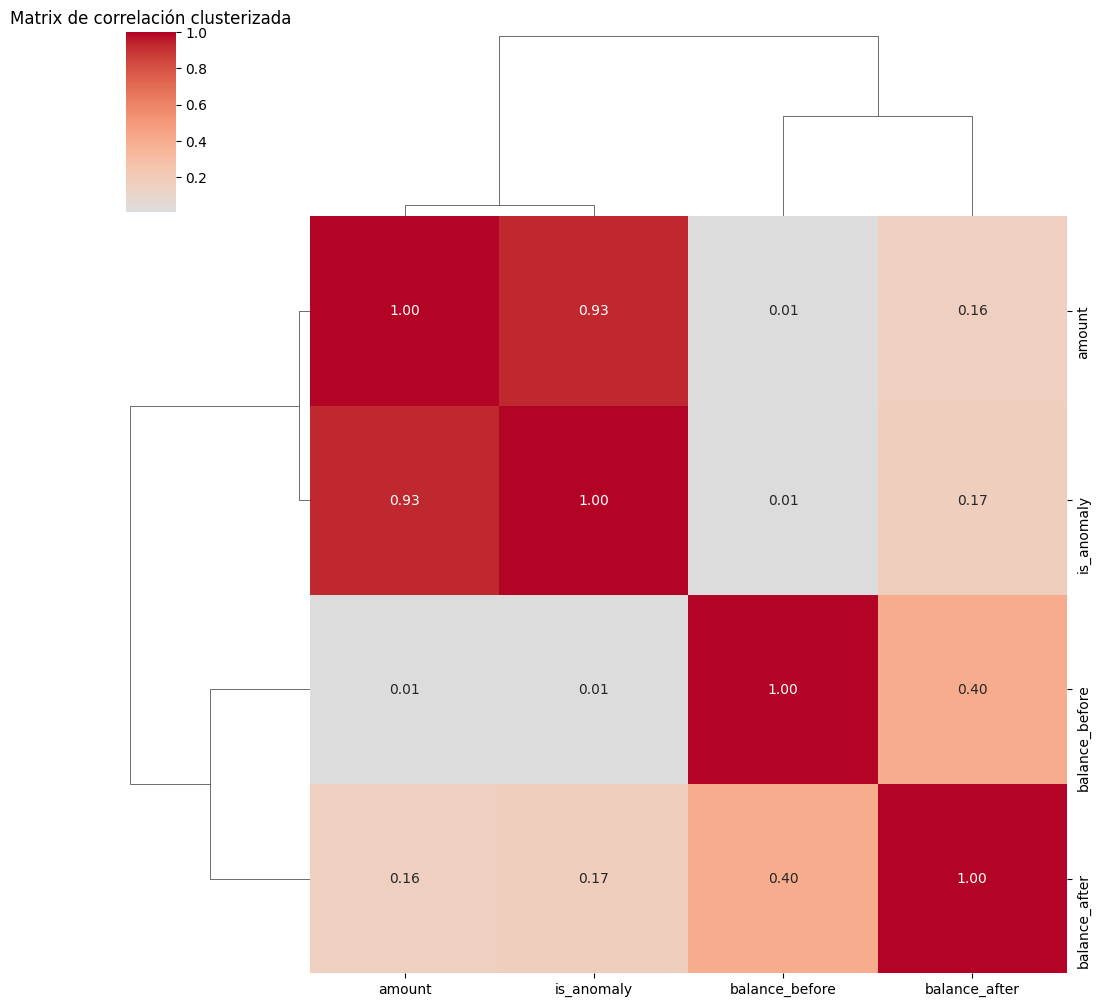

In [27]:
plt.figure(figsize=(12, 10))
sns.clustermap(correlation_matrix,
               annot=True,
               cmap='coolwarm',
               center=0,
               fmt='.2f',
               cbar_kws={"shrink": .8})
plt.title('Matrix de correlación clusterizada')
plt.show()

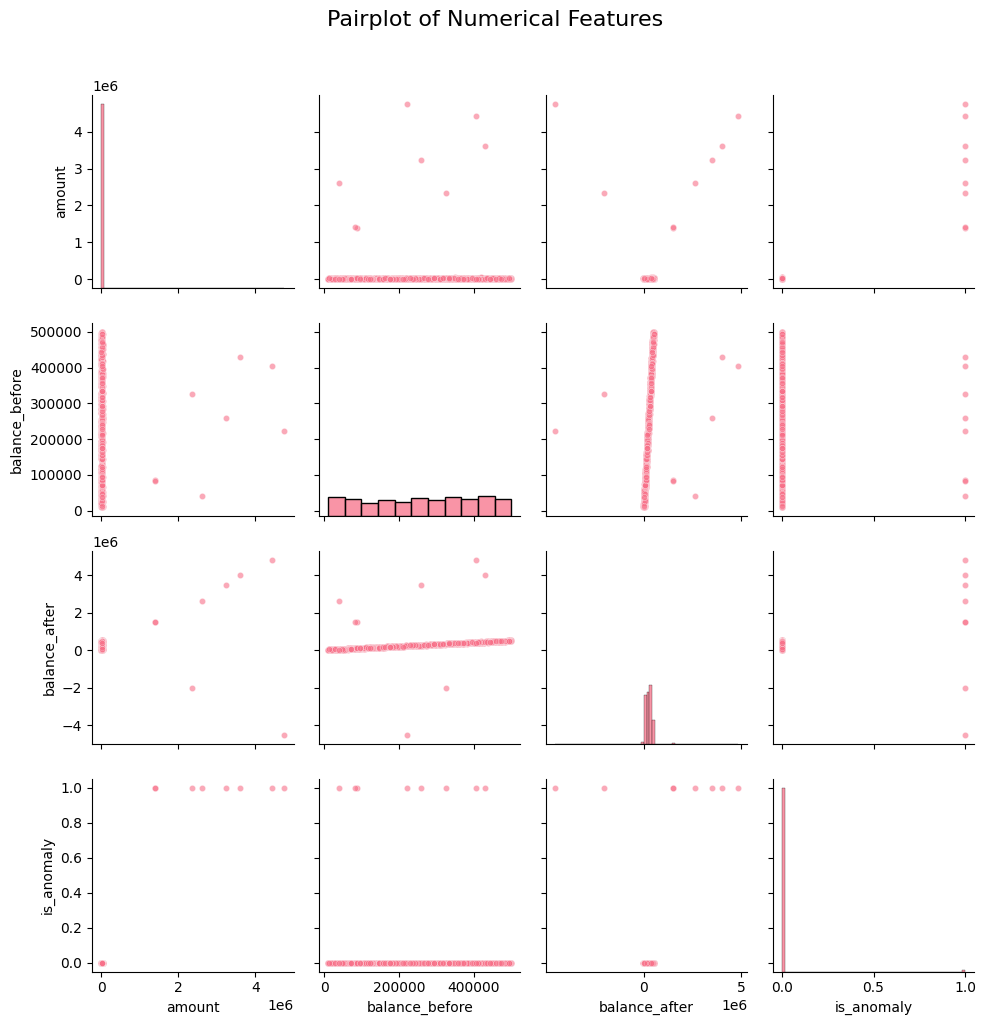

In [24]:
numerical_columns = dataset.select_dtypes(include=[np.number]).columns
pair_plot_data = dataset[numerical_columns].sample(n=min(1000, len(dataset)))
sns.pairplot(pair_plot_data, 
             diag_kind='hist',
             plot_kws={'alpha': 0.6, 's': 20})
plt.suptitle('Pairplot of Numerical Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

De aquí nos damos cuenta que de los datos sampleados, prácticamente se puede distinguir la legitimidad de las transacciones utilizando únicamente la cantidad de la transacción.

## Feature Engineering
Véase que la relación entre las variables indica que balance_after = balance_before +- amount. En general queremos que está relación se conserve, pero también es verdad que los modelos se comportan mejor con datos normalizados. Por lo tanto proponemos dos columnas nuevas. 

Balance_ratio
$$b_{r} = b_{after} / b_{before}$$

Amount to balance ratio

$$Ab_{r} = a / b_{before}$$ 
con a el amount asociado a la transacción

In [45]:
dataset_eng = dataset.copy()

dataset_eng['balance_ratio'] = dataset_eng['balance_after'] / dataset_eng['balance_before'] + 1e-8 
dataset_eng['amount_to_balance_ratio'] = dataset_eng['amount'] / (dataset_eng['balance_before'] + 1e-8)

dataset_eng.describe()

,amount,balance_before,balance_after,is_anomaly,balance_ratio,amount_to_balance_ratio
count,1.000000e+04,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000
mean,4.845413e+04,254697.230031,2.672200e+05,0.010400,1.107914,0.386782
std,3.154764e+05,141770.476819,3.483824e+05,0.101454,4.554413,4.539241
min,1.000000e+03,10008.200000,-4.621451e+06,0.000000,-209.717067,0.002010
25%,1.168429e+04,130533.632500,1.365646e+05,0.000000,0.955964,0.040921
50%,1.818234e+04,254952.050000,2.628995e+05,0.000000,1.038253,0.071634
75%,2.474222e+04,377613.022500,3.852559e+05,0.000000,1.098823,0.141536
max,4.995116e+06,499986.350000,5.417279e+06,1.000000,281.964469,280.964468


In [46]:
# Recalculando la matriz de correlación con las nuevas columnas
correlation_matrix_eng = dataset_eng.select_dtypes(include=[np.number]).corr()

<Figure size 1200x1000 with 0 Axes>

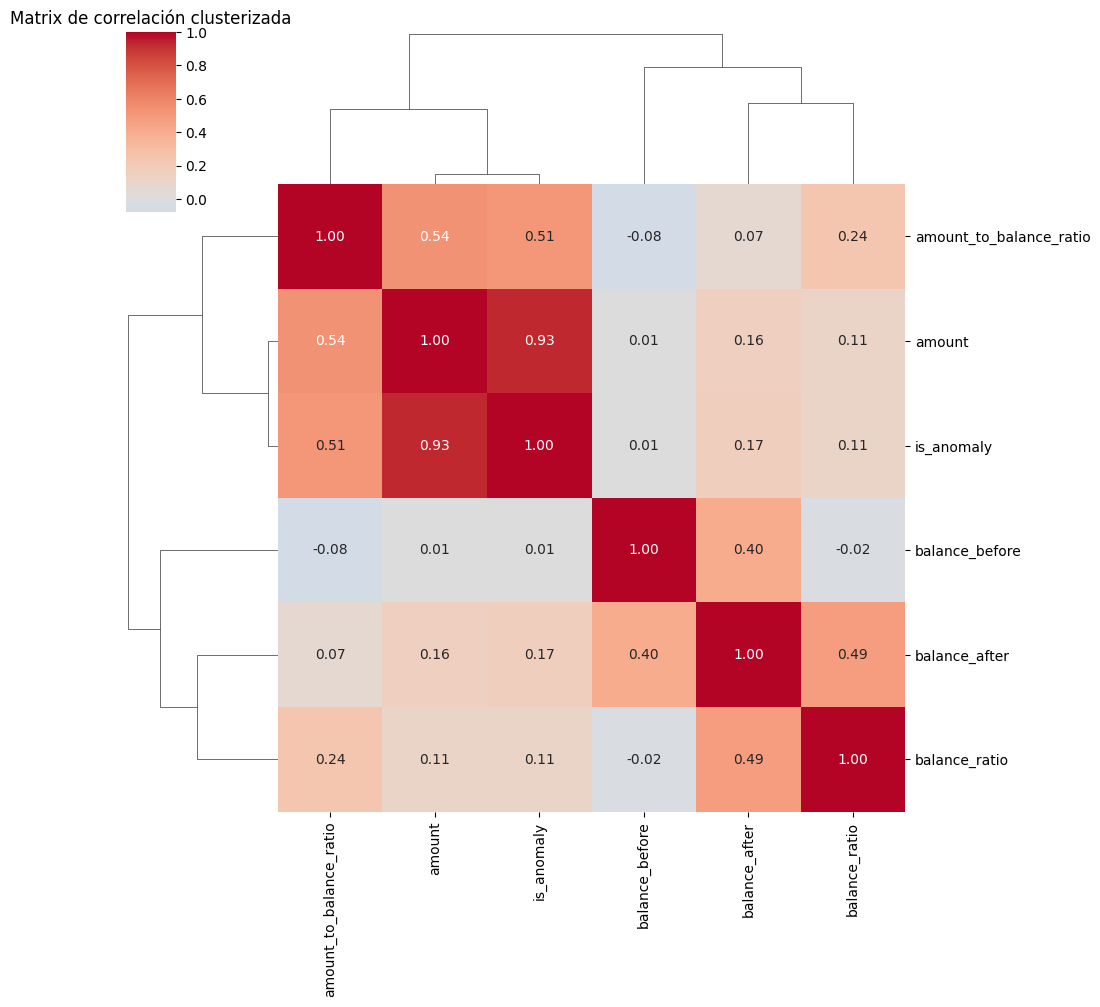

In [47]:
plt.figure(figsize=(12, 10))
sns.clustermap(correlation_matrix_eng,
               annot=True,
               cmap='coolwarm',
               center=0,
               fmt='.2f',
               cbar_kws={"shrink": .8})
plt.title('Matrix de correlación clusterizada')
plt.show()

De aquí podemos ver que hay una relación moderada entre el ratio de la cantidad a añadir a la cuenta contra el saldo inicial respecto a si la transacción es fraudulenta o no. Esto es de esperarse puesto que es poco probable que se realicen transacciones por mucho más dinero que el dispoible actualmente en la cuenta, incluso si es un ingreso.